# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

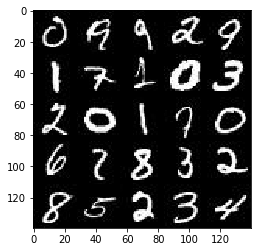

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

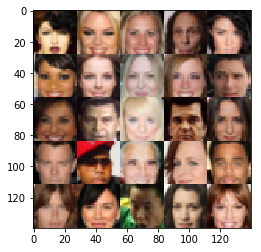

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    kernel = 5
    base_size = 112
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, base_size, kernel, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, base_size*2, kernel, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, base_size*4, kernel, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 7*7*base_size*4))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    kernel = 5
    base_size = 112
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 7*7*base_size*4)

        x1 = tf.reshape(x1, (-1, 7, 7, base_size*4))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, base_size*2, kernel, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, base_size, kernel, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
from datetime import datetime

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
   
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    i = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Scale batch_images
                batch_images = batch_images *2;
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                if i % 128 == 0:
                    print(str(datetime.now()))
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                i = i + 1
                
            # At the end of each epoch, get the losses and print them out
            train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
            train_loss_g = g_loss.eval({input_z: batch_z})

            print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
            # Save losses to view after training
            losses.append((train_loss_d, train_loss_g))

            #show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        print('finished training')
        return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

2017-05-28 18:04:27.091885


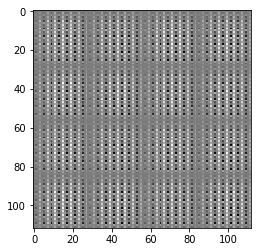

2017-05-28 18:05:22.679158


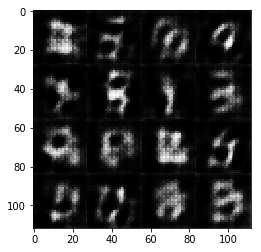

2017-05-28 18:06:18.132590


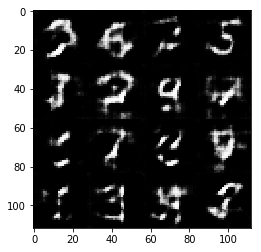

2017-05-28 18:07:13.503339


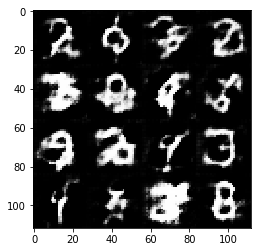

2017-05-28 18:08:08.551357


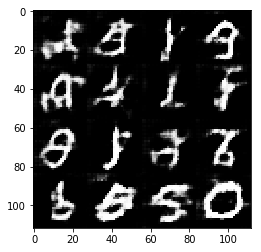

2017-05-28 18:09:03.414713


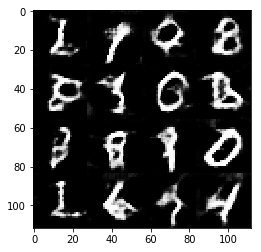

2017-05-28 18:09:58.638048


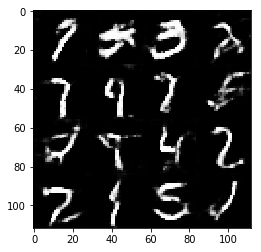

2017-05-28 18:10:54.174659


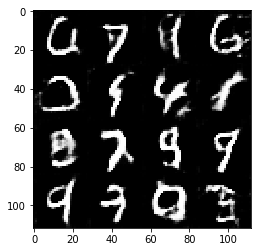

Epoch 1/2... Discriminator Loss: 1.0821... Generator Loss: 0.9236
2017-05-28 18:11:45.770076


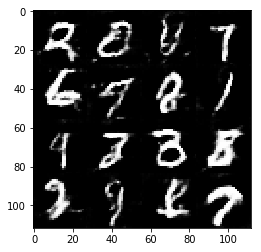

2017-05-28 18:12:35.428573


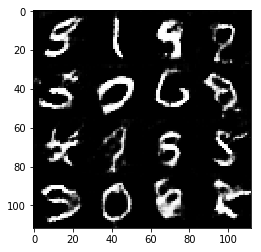

2017-05-28 18:13:25.052580


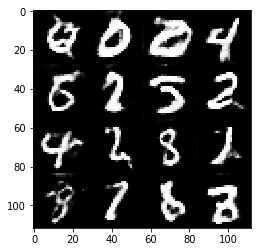

2017-05-28 18:14:14.739644


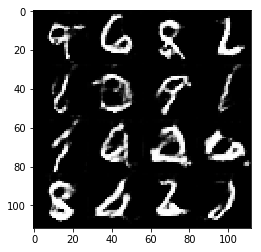

2017-05-28 18:15:04.425435


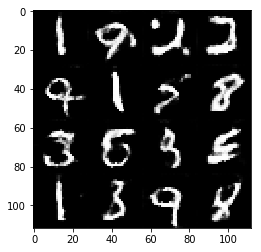

2017-05-28 18:15:54.146961


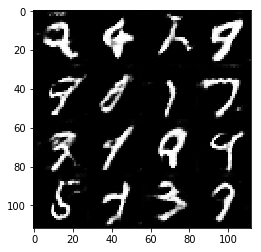

2017-05-28 18:16:43.823725


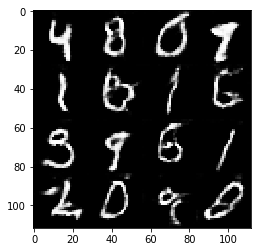

Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 0.6677
finished training
End of run:  64 0.002
2017-05-28 18:17:19.639768


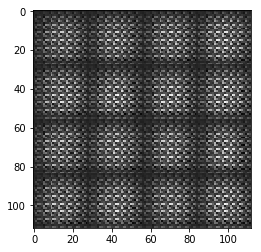

2017-05-28 18:18:09.263704


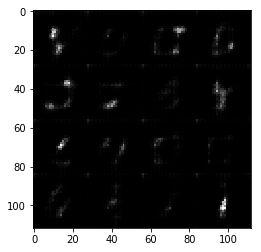

2017-05-28 18:18:58.885508


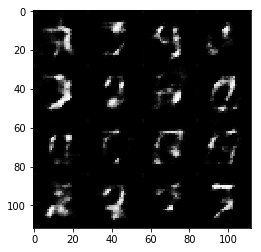

2017-05-28 18:19:48.504862


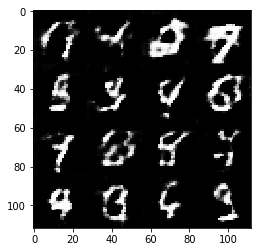

2017-05-28 18:20:38.431011


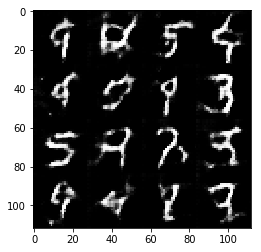

2017-05-28 18:21:28.069980


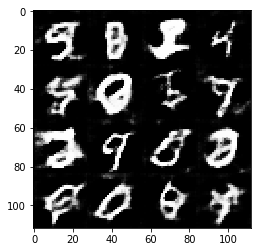

2017-05-28 18:22:17.745922


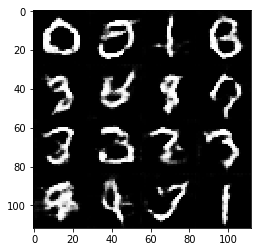

2017-05-28 18:23:07.399787


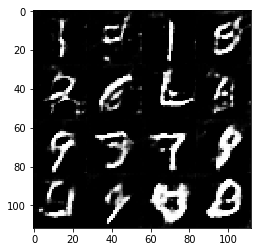

Epoch 1/2... Discriminator Loss: 1.7195... Generator Loss: 0.3309
2017-05-28 18:23:57.265307


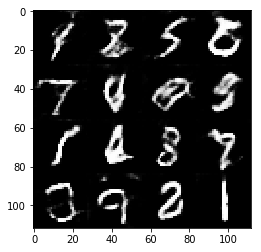

2017-05-28 18:24:46.910219


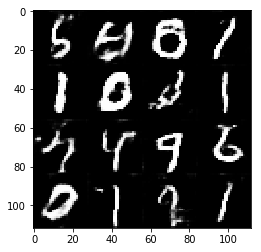

2017-05-28 18:25:36.582371


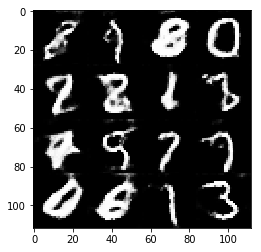

2017-05-28 18:26:26.270997


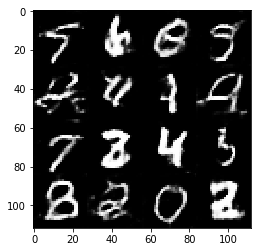

2017-05-28 18:27:15.898407


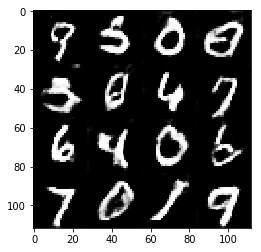

2017-05-28 18:28:05.654292


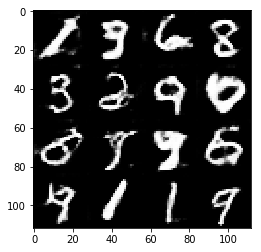

2017-05-28 18:28:55.318631


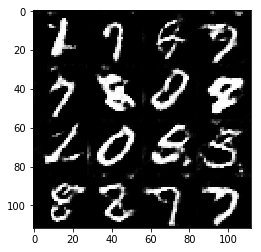

Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 0.9490
finished training
End of run:  64 0.0015
2017-05-28 18:29:31.140620


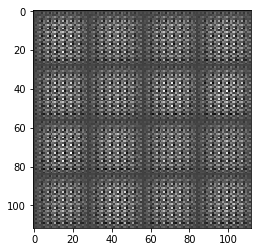

2017-05-28 18:30:20.723476


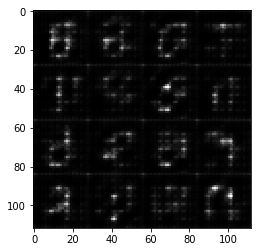

2017-05-28 18:31:10.426754


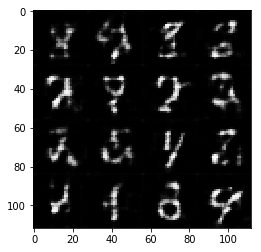

2017-05-28 18:31:59.991334


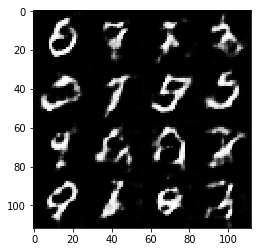

2017-05-28 18:32:49.712475


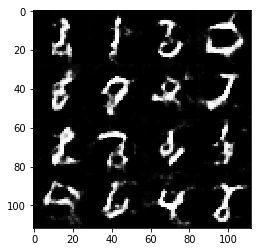

2017-05-28 18:33:39.564622


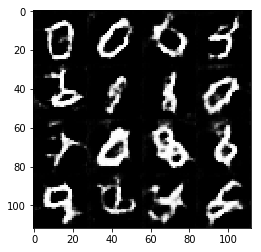

2017-05-28 18:34:29.370515


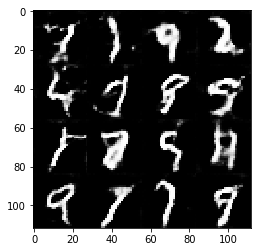

2017-05-28 18:35:19.024675


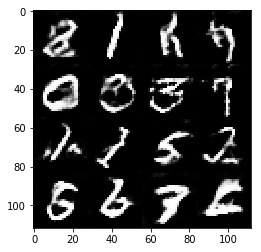

Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.5897
2017-05-28 18:36:08.950951


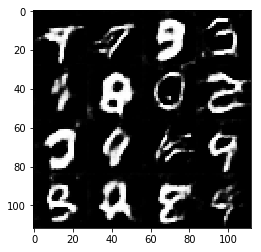

2017-05-28 18:36:58.796974


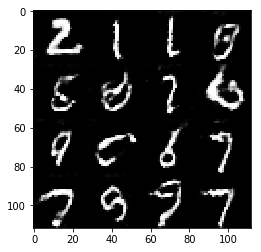

2017-05-28 18:37:48.715842


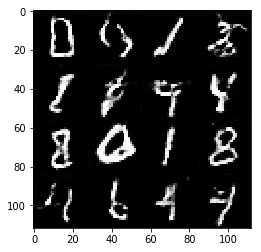

2017-05-28 18:38:38.645456


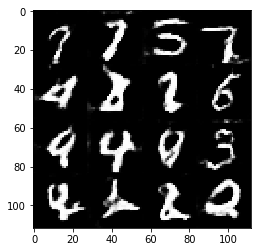

2017-05-28 18:39:28.613290


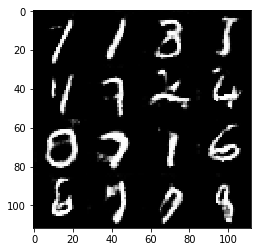

2017-05-28 18:40:18.530941


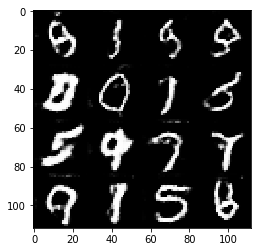

2017-05-28 18:41:08.498655


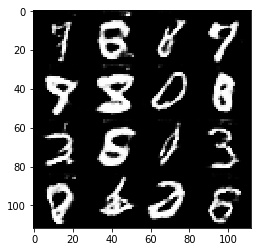

Epoch 2/2... Discriminator Loss: 2.0614... Generator Loss: 0.3095
finished training
End of run:  64 0.001


In [16]:
z_dim = 100
beta1 = 0.5
batch_sizes = [64]
learning_rates = [0.002, 0.0015, 0.001]

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        with tf.Graph().as_default():
            losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)
            print('End of run: ', batch_size, learning_rate)
        tf.reset_default_graph()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

2017-05-28 18:41:45.625271


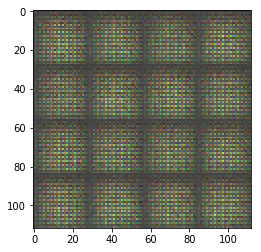

2017-05-28 18:42:51.347836


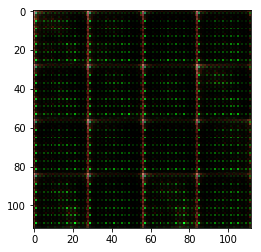

2017-05-28 18:43:55.752315


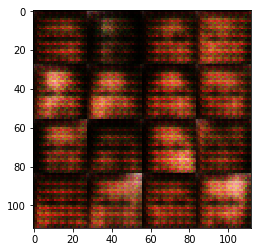

2017-05-28 18:44:59.749426


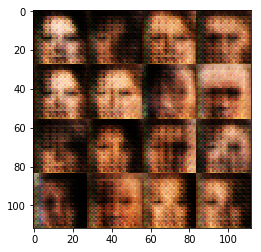

2017-05-28 18:46:04.146547


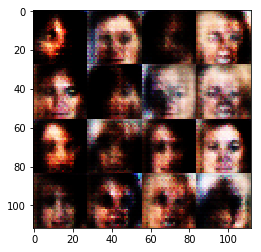

2017-05-28 18:47:08.052359


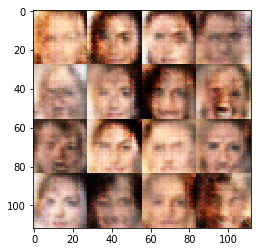

2017-05-28 18:48:12.450844


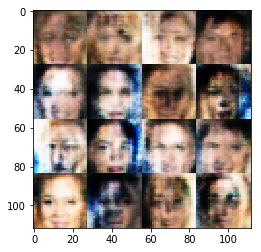

2017-05-28 18:49:16.546955


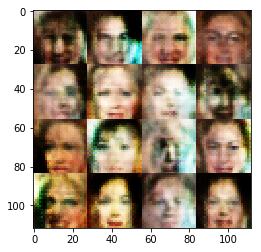

2017-05-28 18:50:20.814275


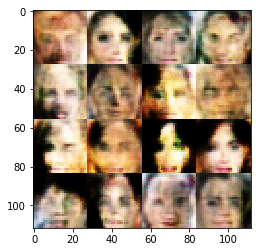

2017-05-28 18:51:24.582629


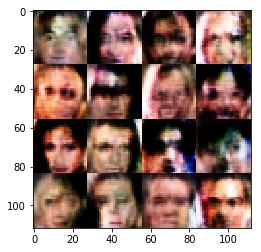

2017-05-28 18:52:28.742582


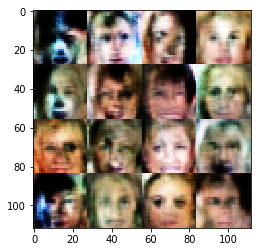

2017-05-28 18:53:33.255168


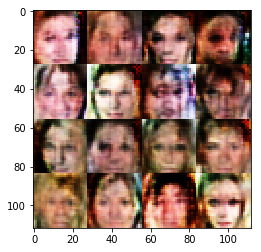

2017-05-28 18:54:37.267039


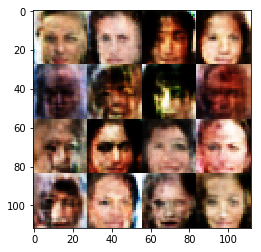

2017-05-28 18:55:41.822437


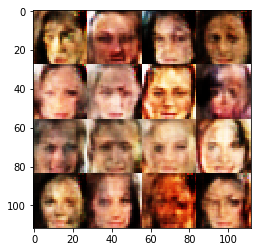

2017-05-28 18:56:46.416757


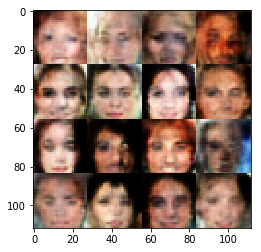

2017-05-28 18:57:52.991575


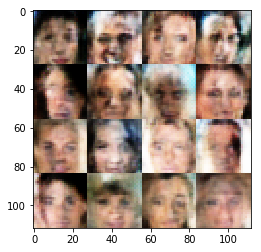

2017-05-28 18:58:57.812943


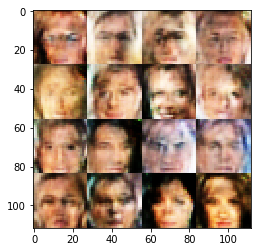

2017-05-28 19:00:02.638923


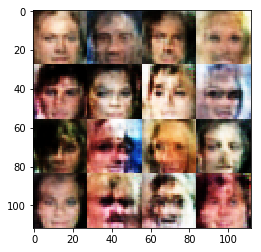

2017-05-28 19:01:07.089759


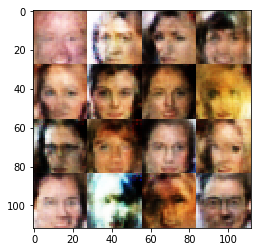

2017-05-28 19:02:11.875698


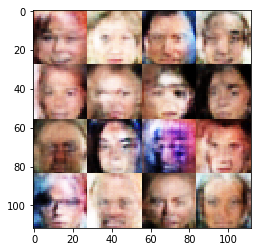

2017-05-28 19:03:17.680198


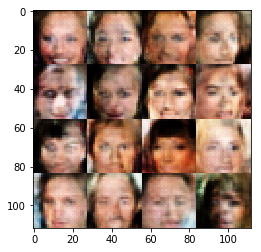

2017-05-28 19:04:21.313268


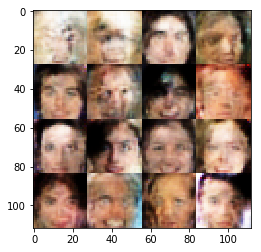

2017-05-28 19:05:26.238854


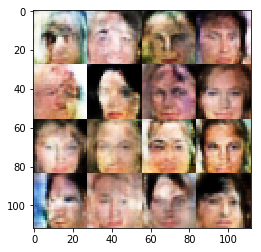

2017-05-28 19:06:32.100919


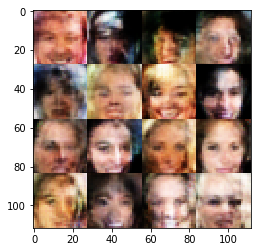

2017-05-28 19:07:41.523192


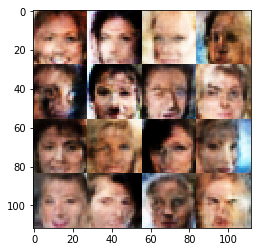

Epoch 1/1... Discriminator Loss: 0.0753... Generator Loss: 5.0022
finished training
End of run:  64 0.0005
2017-05-28 19:08:32.974072


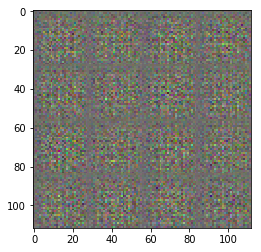

2017-05-28 19:09:30.442851


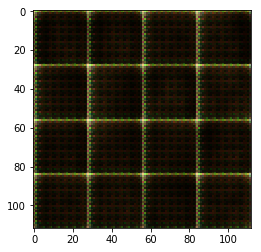

2017-05-28 19:10:27.858297


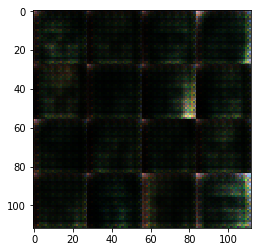

2017-05-28 19:11:25.285230


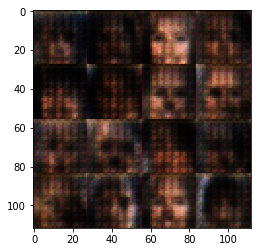

2017-05-28 19:12:22.734130


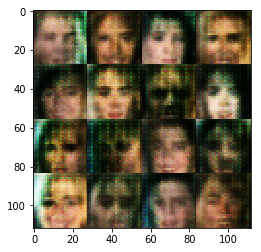

2017-05-28 19:13:20.447406


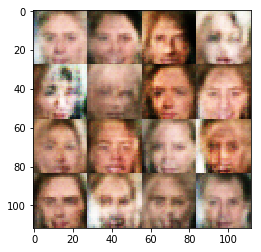

2017-05-28 19:14:17.832403


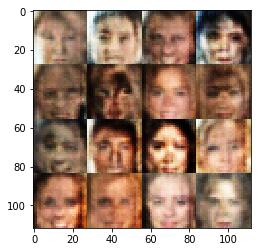

2017-05-28 19:15:15.244811


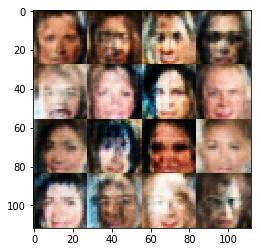

2017-05-28 19:16:12.643645


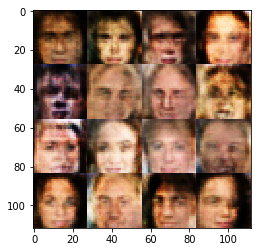

2017-05-28 19:17:10.187754


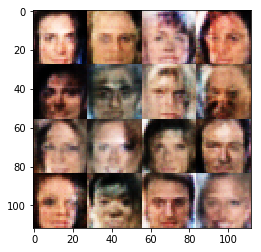

2017-05-28 19:18:07.604276


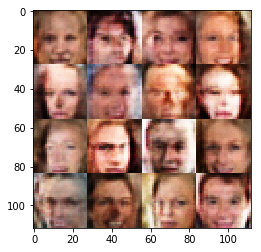

2017-05-28 19:19:05.056549


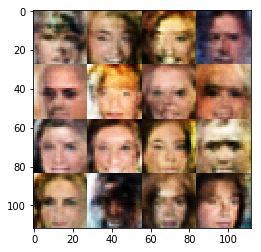

2017-05-28 19:20:02.429254


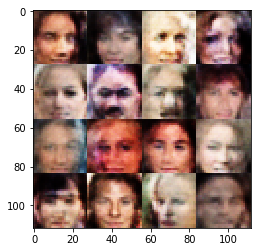

2017-05-28 19:20:59.965338


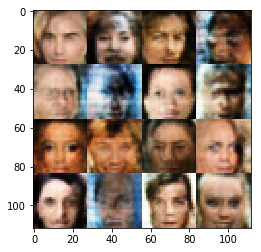

2017-05-28 19:21:57.406140


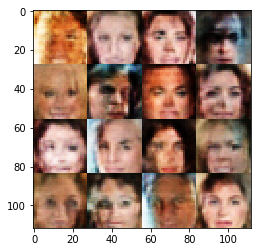

2017-05-28 19:22:54.835779


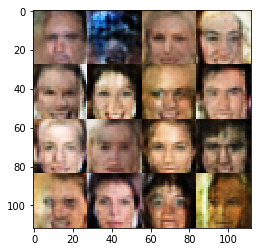

2017-05-28 19:23:52.242430


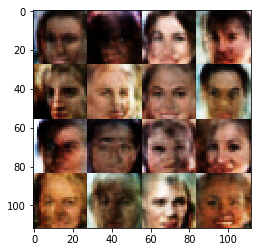

2017-05-28 19:24:49.924373


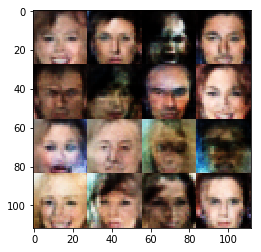

2017-05-28 19:25:47.392388


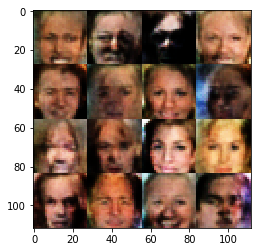

2017-05-28 19:26:44.822455


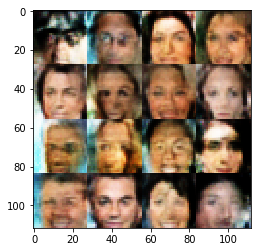

2017-05-28 19:27:42.256261


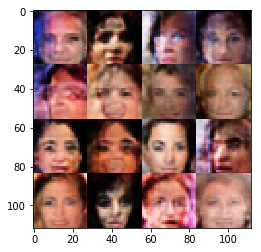

2017-05-28 19:28:39.665812


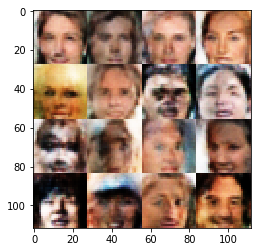

2017-05-28 19:29:37.138400


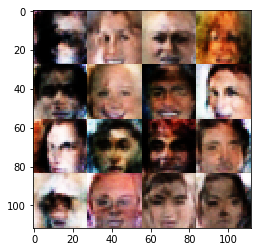

2017-05-28 19:30:34.549841


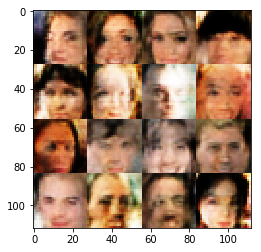

2017-05-28 19:31:31.924522


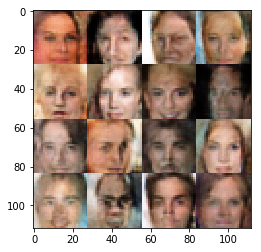

Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 1.4485
finished training
End of run:  64 0.0002
2017-05-28 19:32:17.743090


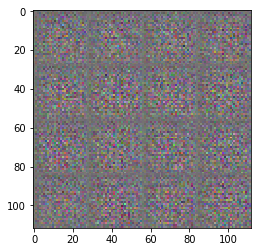

2017-05-28 19:33:15.111100


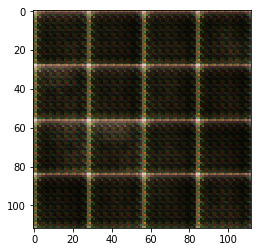

2017-05-28 19:34:12.561535


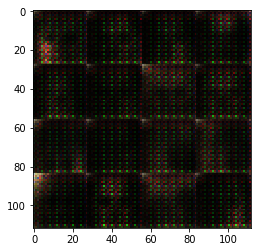

2017-05-28 19:35:10.003085


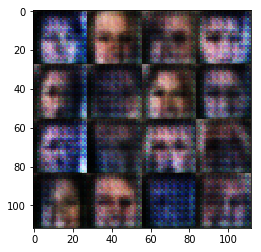

2017-05-28 19:36:07.336519


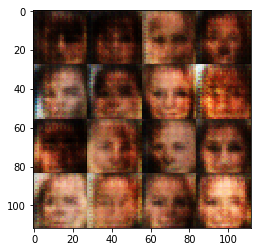

2017-05-28 19:37:04.976818


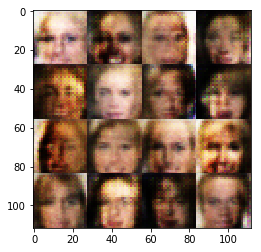

2017-05-28 19:38:02.382312


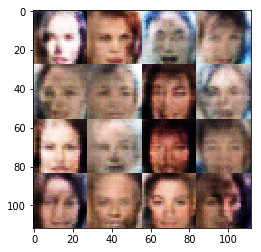

2017-05-28 19:38:59.792910


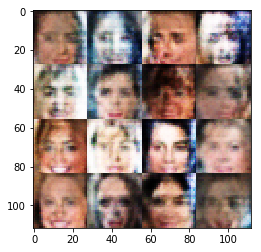

2017-05-28 19:39:57.117085


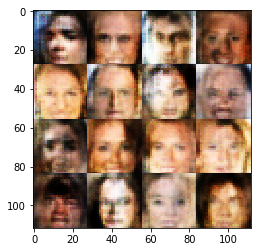

2017-05-28 19:40:54.529296


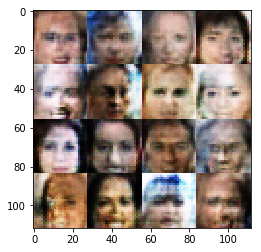

2017-05-28 19:41:51.780371


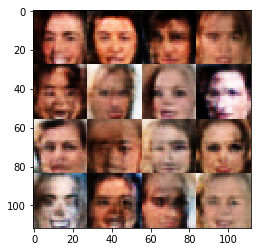

2017-05-28 19:42:49.151392


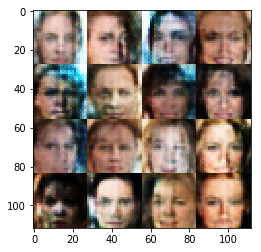

2017-05-28 19:43:46.302640


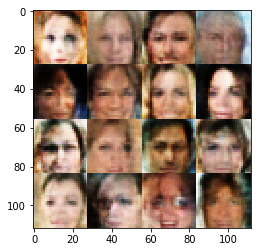

2017-05-28 19:44:43.546900


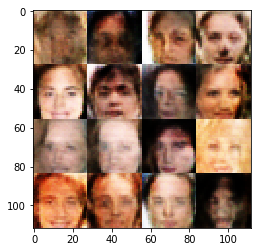

2017-05-28 19:45:40.824857


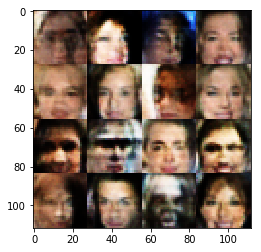

2017-05-28 19:46:38.096393


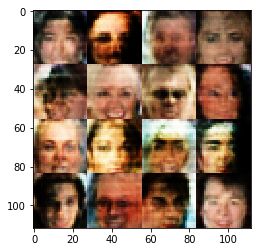

2017-05-28 19:47:35.645390


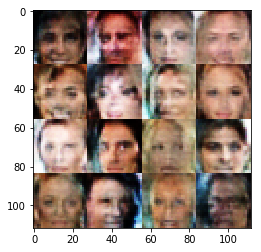

2017-05-28 19:48:32.998714


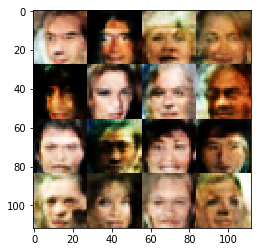

2017-05-28 19:49:30.252449


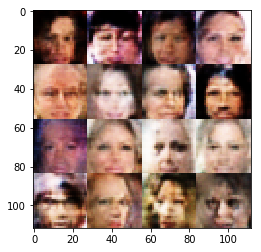

2017-05-28 19:50:27.503859


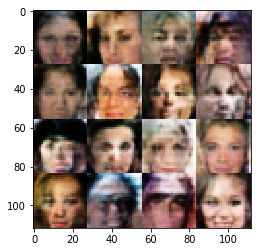

2017-05-28 19:51:24.749306


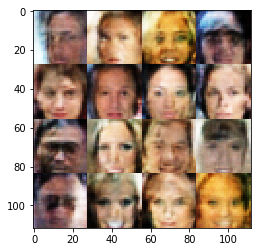

2017-05-28 19:52:21.980474


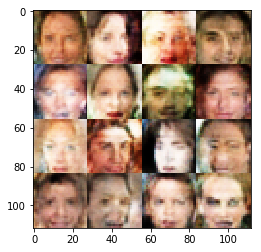

2017-05-28 19:53:19.450566


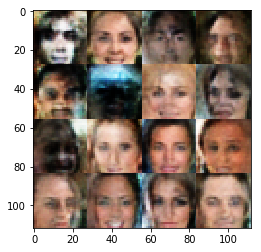

2017-05-28 19:54:16.723110


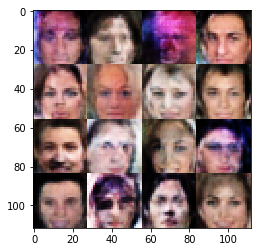

2017-05-28 19:55:14.058393


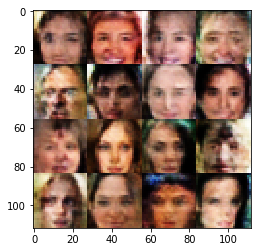

Epoch 1/1... Discriminator Loss: 0.1813... Generator Loss: 2.9098
finished training
End of run:  64 0.00015
2017-05-28 19:56:01.345781


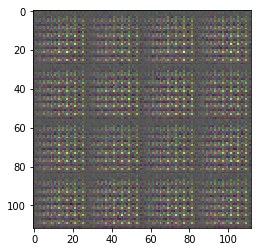

2017-05-28 19:57:39.389296


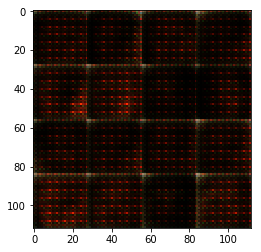

2017-05-28 19:59:17.380327


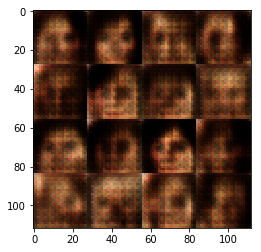

2017-05-28 20:00:55.360347


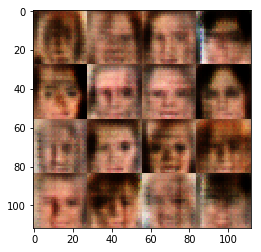

2017-05-28 20:02:33.360097


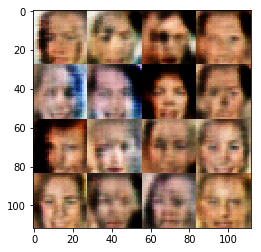

2017-05-28 20:04:11.671652


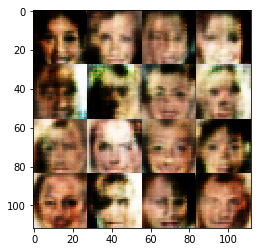

2017-05-28 20:05:49.607588


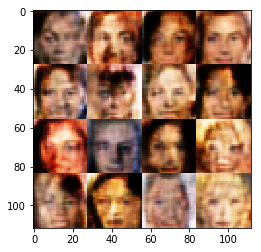

2017-05-28 20:07:27.620781


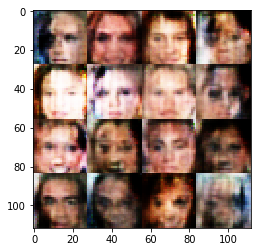

2017-05-28 20:09:05.669244


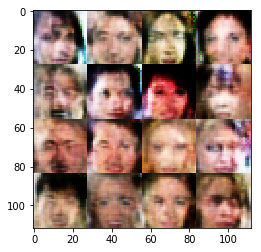

2017-05-28 20:10:43.717221


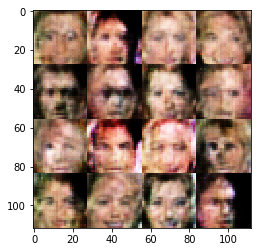

2017-05-28 20:12:21.816671


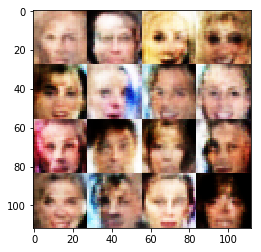

2017-05-28 20:13:59.850296


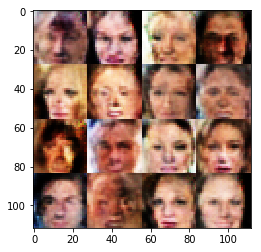

2017-05-28 20:15:37.856439


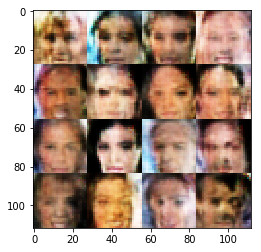

Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.6772
finished training
End of run:  128 0.0005
2017-05-28 20:16:17.264863


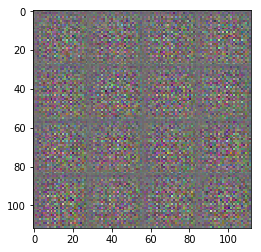

2017-05-28 20:17:55.365291


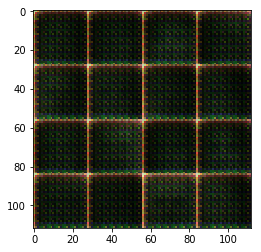

2017-05-28 20:19:33.428501


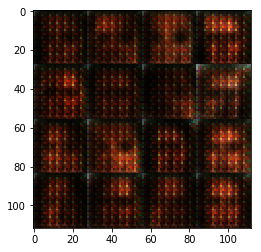

2017-05-28 20:21:11.593683


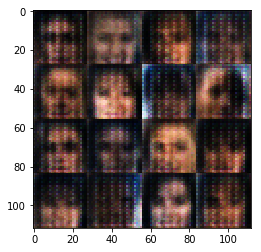

2017-05-28 20:22:49.646595


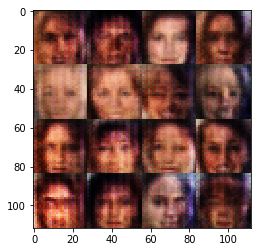

2017-05-28 20:24:27.852227


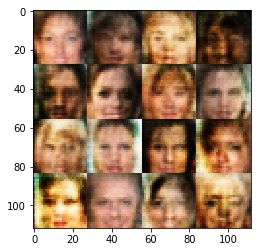

2017-05-28 20:26:06.058187


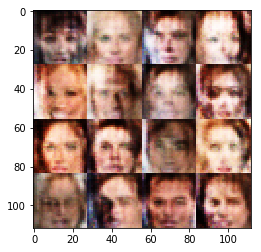

2017-05-28 20:27:44.019645


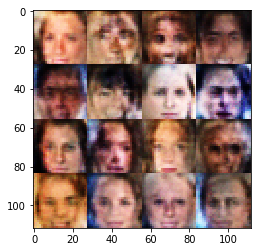

2017-05-28 20:29:22.123594


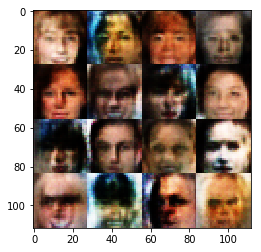

2017-05-28 20:31:00.265448


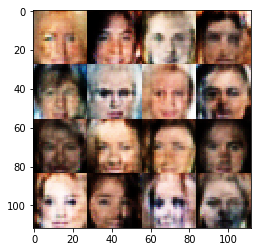

2017-05-28 20:32:38.306612


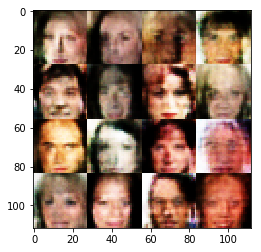

2017-05-28 20:34:16.308889


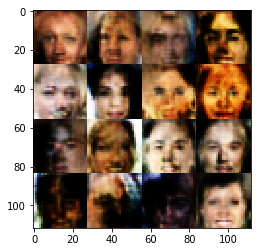

2017-05-28 20:35:54.425939


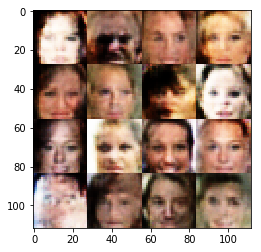

Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.6040
finished training
End of run:  128 0.0002
2017-05-28 20:36:33.878225


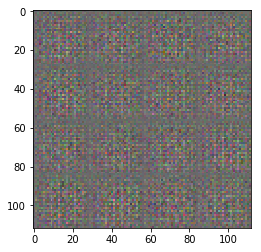

2017-05-28 20:38:12.010813


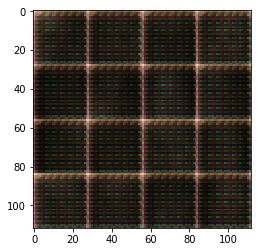

2017-05-28 20:39:50.263708


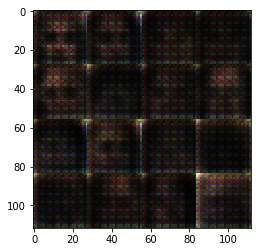

2017-05-28 20:41:28.316937


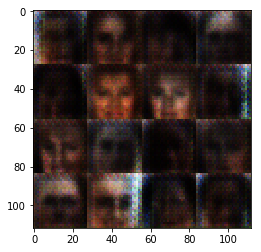

2017-05-28 20:43:06.329973


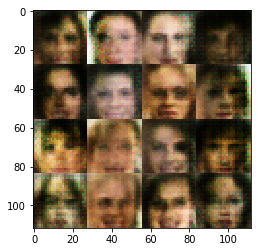

2017-05-28 20:44:44.430566


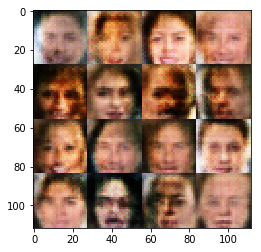

2017-05-28 20:46:22.501167


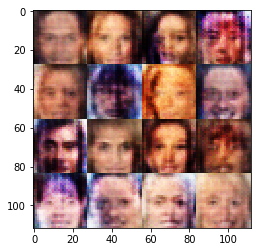

2017-05-28 20:48:00.513803


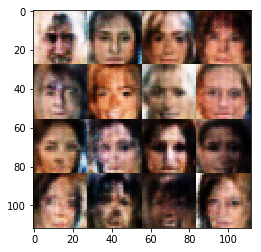

2017-05-28 20:49:38.512130


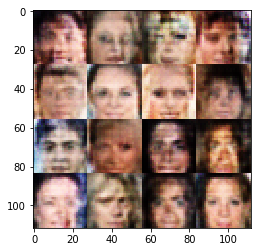

2017-05-28 20:51:16.558006


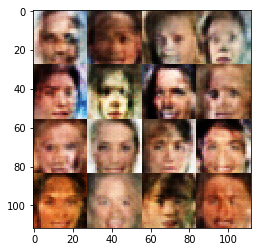

2017-05-28 20:52:54.598092


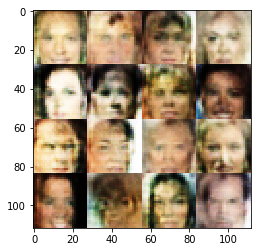

2017-05-28 20:54:32.556121


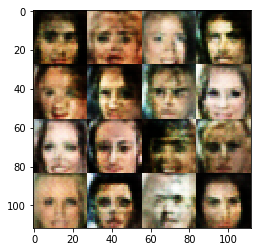

2017-05-28 20:56:10.820669


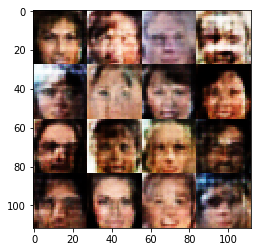

Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 2.4633
finished training
End of run:  128 0.00015


In [17]:
z_dim = 100
beta1 = 0.5
batch_sizes = [64, 128]
learning_rates = [0.0005, 0.0002, 0.00015]


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        with tf.Graph().as_default():
            train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches, celeba_dataset.shape, celeba_dataset.image_mode)
            print('End of run: ', batch_size, learning_rate)
        tf.reset_default_graph()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.